In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [3]:
all_predictions_df = pd.read_csv('./data/yolo_prediction/All.csv')
single_anns_df = pd.read_csv('./data/coco_diff/single_anns/person_anns.csv')

In [4]:
single_anns_df = single_anns_df.rename({'vis_face_ratio': 'head', 'vis_body_ratio': 'torso'}, axis=1)

In [5]:
single_anns_df['foot'] = (single_anns_df['left_ankle_v'] + single_anns_df['right_ankle_v'])/2
single_anns_df['arms'] = (single_anns_df['left_elbow_v'] + single_anns_df['right_elbow_v'])/2
single_anns_df['hand'] = (single_anns_df['left_wrist_v'] + single_anns_df['right_wrist_v'])/2
single_anns_df['legs'] = (single_anns_df['left_knee_v'] + single_anns_df['right_knee_v'])/2
single_anns_df['eyes'] = (single_anns_df['left_eye_v'] + single_anns_df['right_eye_v'])/2

In [6]:
single_anns_df['width'] = single_anns_df['width']/single_anns_df['img_width']
single_anns_df['height'] = single_anns_df['height']/single_anns_df['img_height']

In [7]:
single_anns_df['ID'] = (single_anns_df['Img'].astype(str) + (single_anns_df['person_num']-1).astype(str)).astype(int)

In [8]:
single_anns_df = single_anns_df[['ID', 'Img', 'person_num', 'area_norm', 'img_width', 'img_height', 'x', 'y', 'width', 'height', 'foot', 'legs', 'arms', 'eyes', 'head', 'hand', 'torso']]

In [9]:
single_pred_df = all_predictions_df.copy()

In [10]:
single_pred_df['x_pred'] = np.maximum(single_pred_df['x_center']-(single_pred_df['width'])/2, 0) # To avoid < 0 for rounding errors
single_pred_df['y_pred'] = np.maximum(single_pred_df['y_center']-(single_pred_df['height'])/2, 0) # To avoid < 0 for round errors

In [11]:
single_pred_df = single_pred_df[['ID', 'Img_ID', 'Confidence', 'x_pred', 'y_pred', 'width', 'height']]
single_pred_df = single_pred_df.rename({'width': 'width_pred', 'height': 'height_pred'}, axis=1)

In [12]:
single_anns_df['x'] = single_anns_df['x']/single_anns_df['img_width']
single_anns_df['y'] = single_anns_df['y']/single_anns_df['img_height']

In [13]:
single_merged = pd.merge(single_anns_df.drop(['ID'], axis=1), single_pred_df, left_on='Img', right_on='Img_ID', how='inner')

In [14]:
def calculate_iou_vectorized(df):
    x1_inter = df[['x', 'x_pred']].max(axis=1)
    y1_inter = df[['y', 'y_pred']].max(axis=1)
    x2_inter = (df['x'] + df['width']).clip(upper=(df['x_pred'] + df['width_pred']))
    y2_inter = (df['y'] + df['height']).clip(upper=(df['y_pred'] + df['height_pred']))

    inter_width = (x2_inter - x1_inter).clip(lower=0)
    inter_height = (y2_inter - y1_inter).clip(lower=0)
    intersection = inter_width * inter_height

    area_coco = df['width'] * df['height']
    area_yolo = df['width_pred'] * df['height_pred']
    union = area_coco + area_yolo - intersection

    return intersection / union 

In [15]:
single_merged['IoU'] = calculate_iou_vectorized(single_merged)

result_df = single_merged[single_merged['IoU'] > 0.5]
result_df[['ID', 'Img', 'Confidence', 'foot', 'head', 'torso', 'legs', 'arms', 'eyes', 'hand', 'area_norm']]


,ID,Img,Confidence,foot,head,torso,legs,arms,eyes,hand,area_norm
0,5224180,522418,0.778439,0.0,0.6,0.250,0.0,0.50,0.5,0.00,0.206137
2,1289391,128939,0.482966,0.0,0.0,0.375,0.0,0.50,0.0,0.00,0.005815
8,1289393,128939,0.324429,0.0,0.0,0.000,0.0,0.00,0.0,0.00,0.000791
13,1289390,128939,0.615011,0.0,0.0,0.500,0.0,0.50,0.0,0.50,0.052526
15,1289392,128939,0.387029,0.0,0.0,0.500,0.0,0.50,0.0,0.50,0.052526
...,...,...,...,...,...,...,...,...,...,...,...
31345,3574560,357456,0.875804,0.0,1.0,1.000,0.0,1.00,1.0,1.00,0.165172
31349,3574561,357456,0.359971,0.0,1.0,0.125,0.0,0.00,1.0,0.00,0.234665
31350,3574562,357456,0.274657,0.0,1.0,0.125,0.0,0.00,1.0,0.00,0.234665
31352,5160491,516049,0.488207,0.0,0.6,0.625,0.5,0.50,0.5,1.00,0.186221


In [16]:
attr_list = ['foot', 'torso', 'legs', 'arms', 'hand', 'eyes', 'head']
result_df = result_df[result_df[attr_list].sum(axis=1)>0]

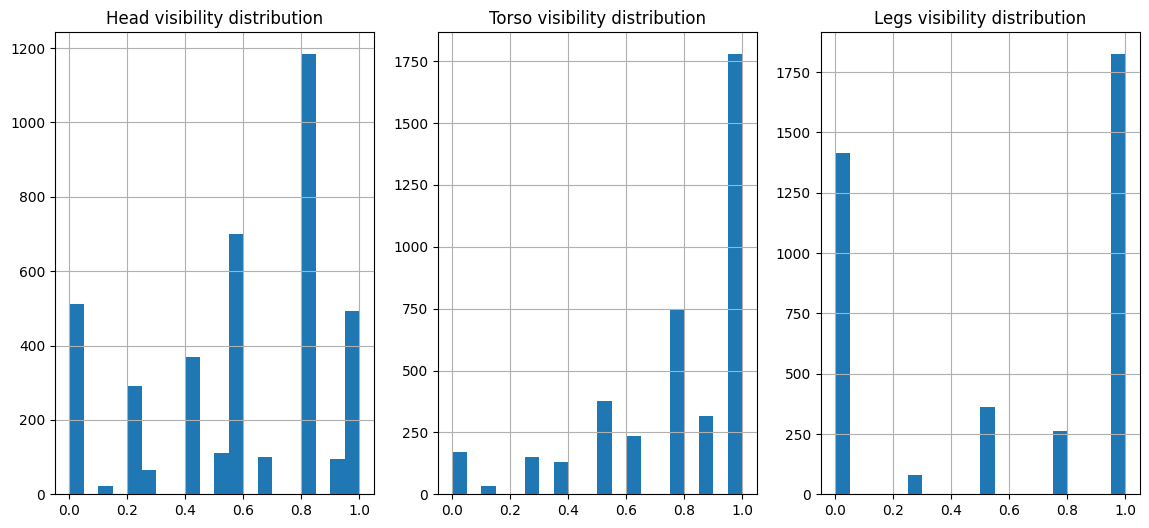

In [17]:
plt.figure(figsize=(14, 6))
plt.subplot(1, 3, 1)
plt.title('Head visibility distribution')
result_df['head'].hist(bins=20)
plt.subplot(1, 3, 2)
plt.title('Torso visibility distribution')
result_df['torso'].hist(bins=20)
plt.subplot(1, 3, 3)
plt.title('Legs visibility distribution')
result_df['legs'].hist(bins=20)
plt.show()

We can see that, compared to torso and legs, head appears to be less visible on average (due to its size). Torso is fairly visible in the vast majority of people, while legs tend to be either completely invisible or completely visible.

In [18]:
attr_list = ['foot', 'torso', 'legs', 'arms', 'hand']
result_df['head_compl'] = result_df[attr_list].sum(axis=1)
attr_list = ['foot', 'legs', 'arms', 'hand', 'head', 'eyes']
result_df['torso_compl'] = result_df[attr_list].sum(axis=1)
attr_list = ['foot', 'torso', 'arms', 'hand', 'head', 'eyes']
result_df['legs_compl'] = result_df[attr_list].sum(axis=1)


In [36]:
no_head = result_df[result_df['head']==0].head(50)[['head_compl', 'Confidence', 'ID', 'Img', 'area_norm']]
no_torso = result_df[result_df['torso']==0].head(50)[['torso_compl', 'Confidence', 'ID', 'Img', 'area_norm']]
no_legs = result_df[result_df['legs']==0].head(50)[['legs_compl', 'Confidence', 'ID', 'Img', 'area_norm']]



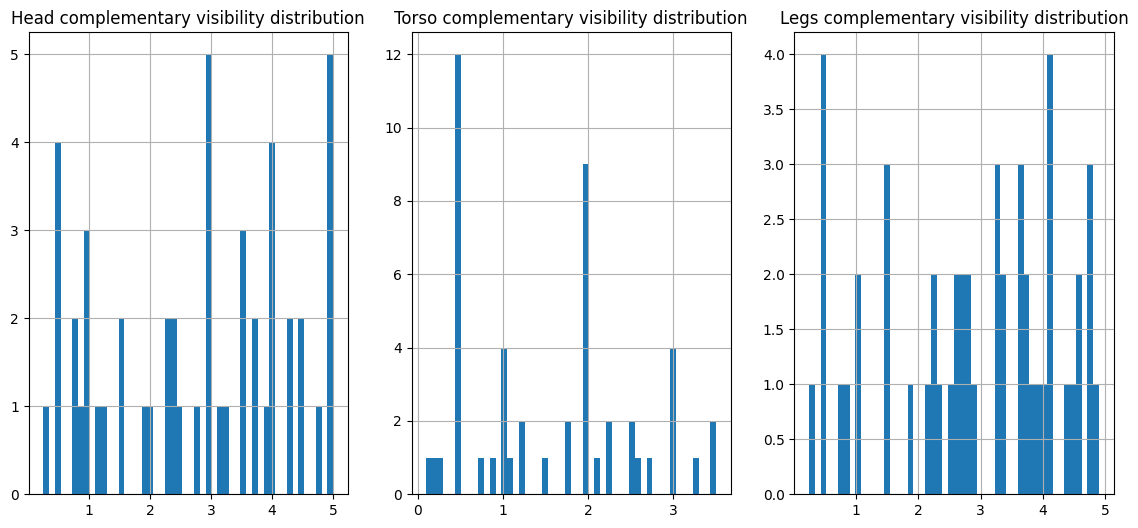

In [20]:
plt.figure(figsize=(14, 6))
plt.subplot(1, 3, 1)
plt.title('Head complementary visibility distribution')
no_head['head_compl'].hist(bins=50)
plt.subplot(1, 3, 2)
plt.title('Torso complementary visibility distribution')
no_torso['torso_compl'].hist(bins=50)
plt.subplot(1, 3, 3)
plt.title('Legs complementary visibility distribution')
no_legs['legs_compl'].hist(bins=50)
plt.show()

We can see that head and legs follow a quite similar distribution, while for torso, when it's not visible, it's very hard that other features are visible (of course due to its position).

In [35]:
print('Confidence of detection of people with not visible head', no_head['Confidence'].mean())
print('Complementary visibility of head', no_head['head_compl'].mean())
print('-'*20)
print('Confidence of detection of people with not visible torso', no_torso['Confidence'].mean())
print('Complementary visibility of torso', no_torso['torso_compl'].mean())
print('-'*20)
print('Confidence of detection of people with not visible legs', no_legs['Confidence'].mean())
print('Complementary visibility of legs', no_legs['legs_compl'].mean())

Confidence of detection of people with not visible head 0.6521254163980484
Complementary visibility of head 2.7575
--------------------
Confidence of detection of people with not visible torso 0.6150216555595398
Complementary visibility of torso 1.561
--------------------
Confidence of detection of people with not visible legs 0.7291855949163437
Complementary visibility of legs 2.8695


Following the prior distributions, we can understand, looking at this values, that the low value of confidence for people with not visible torso is caused also by the low complementary visibility. On the other hand, legs and head share similar values of complementary visibility, while their confidence is way different (close to 10% gap)

In [69]:
def plot_scatter(var, df, title):
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(df[var],df['Confidence'], c=df['area_norm'], s=100, cmap='cividis', alpha=0.8, edgecolor='k')

    colorbar = plt.colorbar(scatter)
    colorbar.set_label('Person Area', fontsize=12)

    plt.xlabel(var, fontsize=12)
    plt.ylabel('Confidence', fontsize=12)
    plt.title(title, fontsize=14)
    
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()


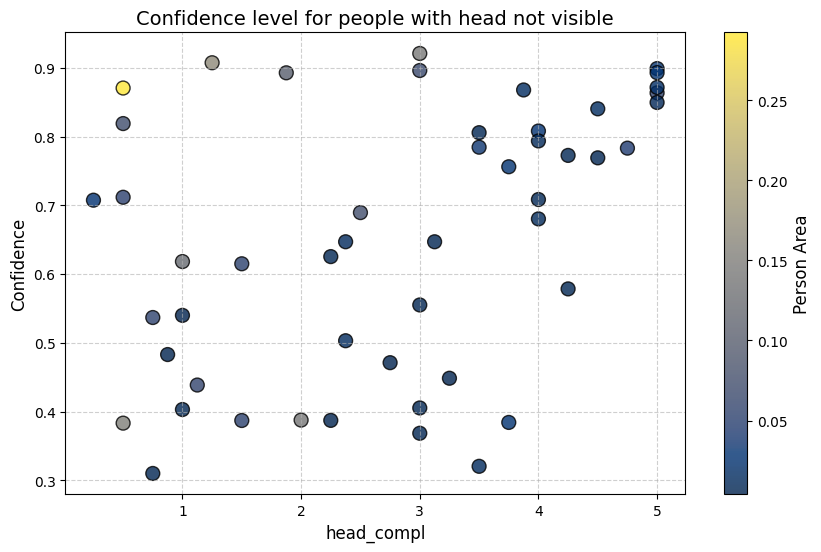

In [70]:
plot_scatter('head_compl', no_head, 'Confidence level for people with head not visible')

We can see that confidence level for people with head not visible follows a distribution close to exponential, excluding some outliers. It's easy to detect that values outside of this parabola are people whose area is very big, leading to an easier detection. In summary, for people with a normal size, confidence level is affected much by head visibility: without clear visibility of 80% of other features, the confidence level drops much, while, of course, with clear visibility of all the other features, the confidence level stays quite high.

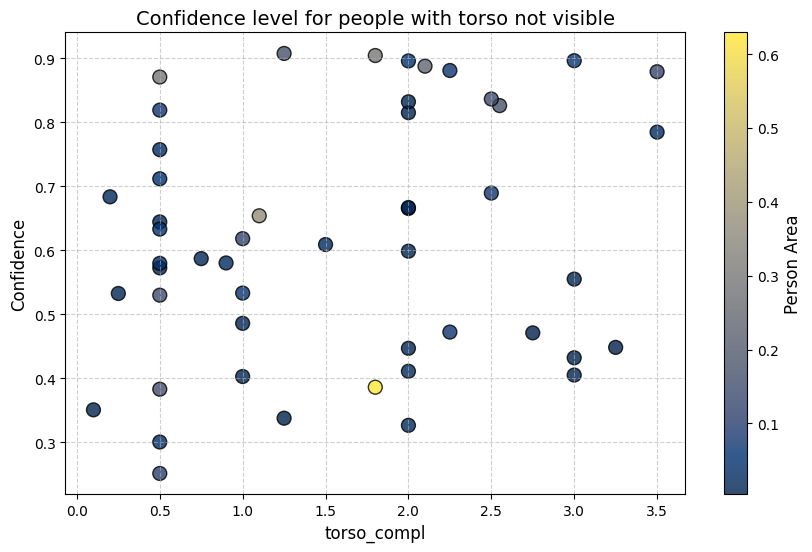

In [23]:
plot_scatter('torso_compl', no_torso, 'Confidence level for people with torso not visible')

We can see that confidence level for people with torso doesn't follow any distribution. As seen earlier, the distribution of torso_compl is unbalanced, with many people having only 0.5 of torso_compl. Due to this reason, we can't generalize very well, but, on average, even with low values of torso_compl and small areas, confidence values can reach close to 90%. Torso, of course, is a key feature, as it's the biggest one, but we can say that for small people is not as relevant as head for confidence detection.

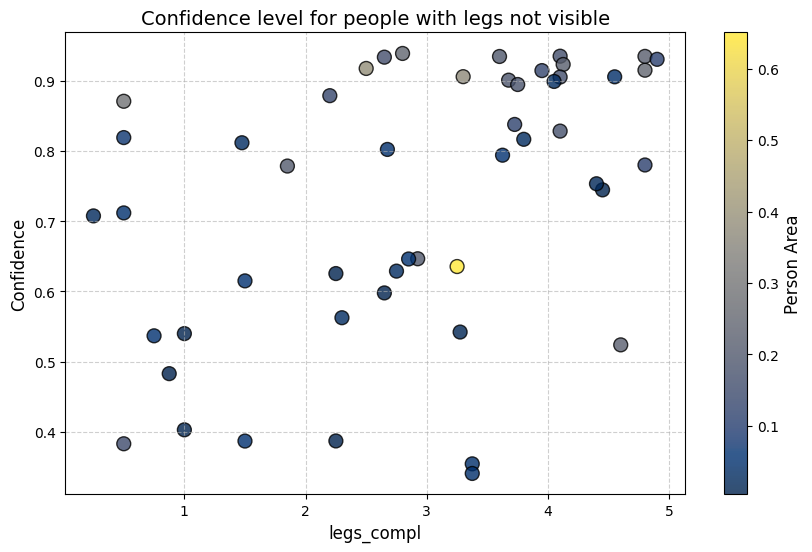

In [24]:
plot_scatter('legs_compl', no_legs, 'Confidence level for people with legs not visible')

Here, instead, the confidence level for people with legs not visible looks following a linear distribution, but with many outliers: there are many values above 90% of confidence even with legs_compl values lower than 4. Looking at this plot, we can say that legs visibility relevance is strictly correlated with both area and complementary features. So with low values of complementary features, people are not detected well (except for the ones with large area values), but with medium values of complementary features, people are already well detected, meaning that legs visibility is not that crucial.

In [ ]:
attr_list = ['foot', 'legs', 'arms', 'hand']
result_df['head_torso_compl'] = result_df[attr_list].sum(axis=1)
no_head_no_torso = result_df[(result_df['head']==0)&(result_df['torso']==0)].head(50)[['head_torso_compl', 'Confidence', 'ID', 'Img', 'area_norm']]

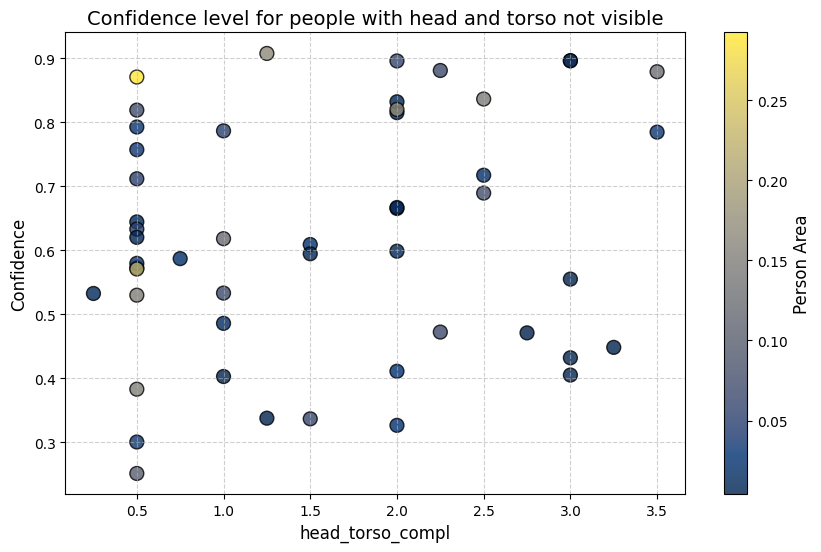

In [26]:
plot_scatter('head_torso_compl', no_head_no_torso, 'Confidence level for people with head and torso not visible')

Here we analyzed the confidence level for people with both head and torso not visible and we can see that, of course, head_torso_compl range shortens, covering only from 0.5 to 3.5, but then we can see that values around 0.8 and above have quite all grey/yellow color, meaning that confident detections in people with both head and torso covered can be achieved only when they cover a big area. Moreover, if they represent a big portion of area, the detection isn't sistematically correct.

In [30]:
def plot_hexbin(var, df, title):
    plt.figure(figsize=(10, 6))
    
    hexbin = plt.hexbin(df[var], df['Confidence'], C=df['area_norm'], gridsize=50, cmap='cividis', reduce_C_function=np.mean)
    
    colorbar = plt.colorbar(hexbin)
    colorbar.set_label('Average Person Area', fontsize=12)

    plt.xlabel(var, fontsize=12)
    plt.ylabel('Confidence', fontsize=12)
    plt.title(title, fontsize=14)

    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()


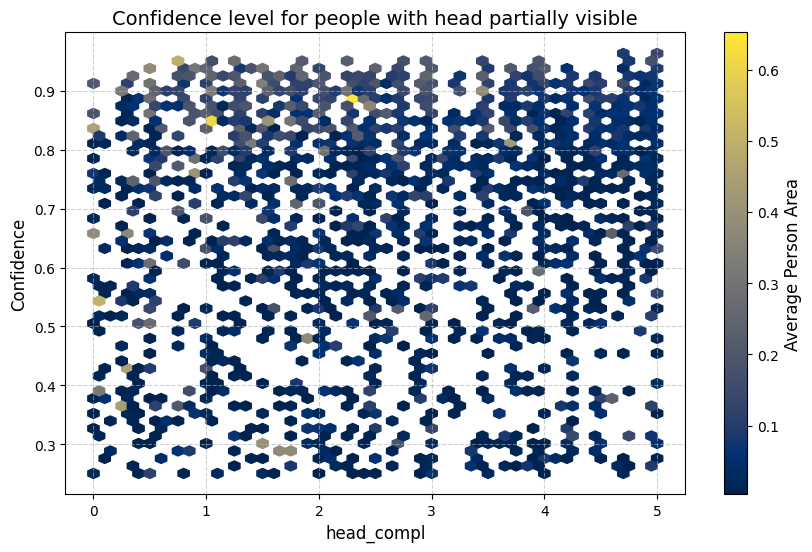

In [31]:
part_head = result_df[(result_df['head']>0)&(result_df['head']<1)]
plot_hexbin('head_compl', part_head, 'Confidence level for people with head partially visible')

Here we analyzed the confidence level for people with head partially visible: we can see that the density on the top part of the plot (so good detections) appear when either all other features are clearly visible or the area of the person is big. For the rest, of the cases, the prediction has low confidence (less than 0.7)

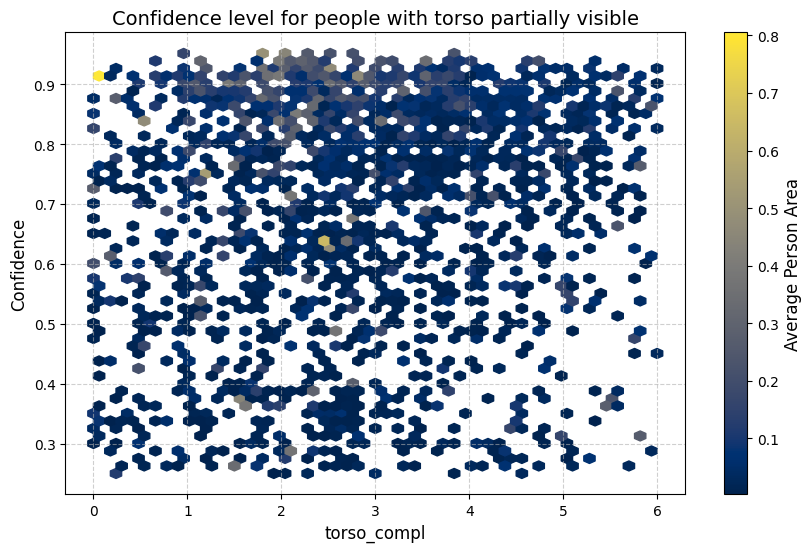

In [32]:
part_torso = result_df[(result_df['torso']>0)&(result_df['torso']<1)]
plot_hexbin('torso_compl', part_torso, 'Confidence level for people with torso partially visible')

Here, instead, we can see that the density isn't anymore on the top right part, but in the top middle, meaning that people with torso partially visible, even if only half of the other features are visible, get a high level of confidence.

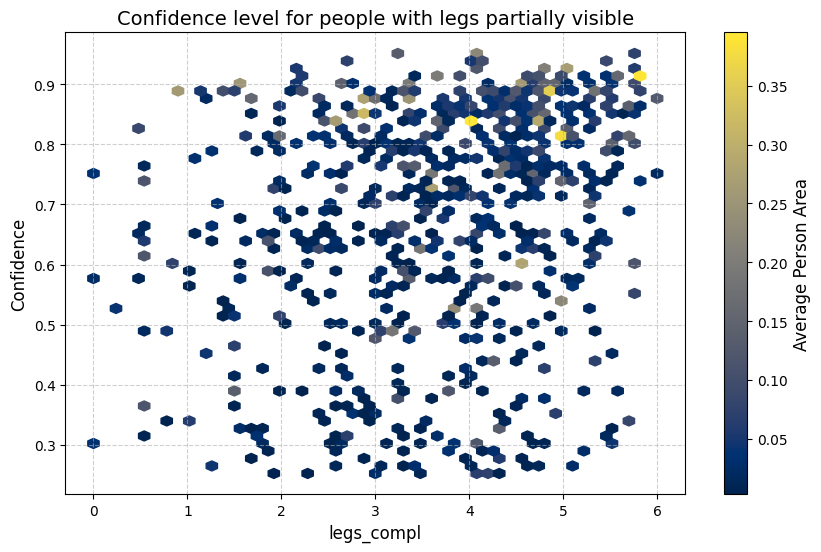

In [33]:
part_legs = result_df[(result_df['legs']>0)&(result_df['legs']<1)]
plot_hexbin('legs_compl', part_legs, 'Confidence level for people with legs partially visible')

Legs partially_visible, instead, here look pairing up with at least half of the other features. There are cases where detection is poor, even with a high number of features visible, but that's primarily caused by the size of the person. The density is mainly in the top right corner, also with some yellow dots, indicating the huge size of the person considered. So legs don't appear as a discriminant feature.